# Grad-ECLIP: Explication de l'interprétabilité des modèles Vision-Language

Ce notebook implémente la méthode **Grad-ECLIP** présentée dans l'article de recherche, qui permet de générer des cartes d'attention explicables pour les modèles Vision-Language comme CLIP.

## Contexte et motivation

Les modèles Vision-Language comme CLIP peuvent associer des images à du texte, mais leur fonctionnement interne reste opaque. **Grad-ECLIP** propose une méthode pour visualiser quelles parties d'une image le modèle "regarde" quand il traite un prompt textuel donné.

## Concepts clés abordés :

1. **CLIP** : Modèle pré-entraîné pour l'alignement vision-texte
2. **Attention Maps** : Visualisation des zones importantes dans l'image
3. **Grad-CAM vs Grad-ECLIP** : Comparaison de méthodes d'explication
4. **Dense Encoding** : Extraction des features par patch d'image


In [2]:
# Installation des dépendances nécessaires
#! pip install ftfy regex tqdm
#! pip install git+https://github.com/openai/CLIP.git

## 1. Importation des librairies et configuration

Nous importons les librairies nécessaires pour manipuler CLIP et traiter les images.


In [2]:
import math
import torch
import torch.nn.functional as F
import torchvision.transforms as T
from torchvision.transforms import Compose, Resize, ToTensor, Normalize, InterpolationMode
import clip
from open_clip import create_model_from_pretrained


import cv2
import numpy as np
    
device = "cpu" #"cuda" if torch.cuda.is_available() else "cpu"
clipmodel, preprocess = clip.load("ViT-B/16", device=device)
clip_inres = clipmodel.visual.input_resolution
clip_ksize = clipmodel.visual.conv1.kernel_size

print("[clip resolution]:", clip_inres)
print("[clip kernel size]:", clip_ksize)

AttributeError: partially initialized module 'torchvision' has no attribute 'extension' (most likely due to a circular import)

## 2. Fonctions de préprocessing personnalisées

### Pourquoi un préprocessing spécial ?

Contrairement au préprocessing standard de CLIP qui redimensionne les images à une taille fixe (224x224), notre approche conserve le ratio d'aspect de l'image en l'ajustant aux dimensions des patches du Vision Transformer.

**Avantage** : Évite la déformation de l'image et permet une meilleure correspondance spatiale entre les cartes d'attention et l'image originale.


In [ ]:
# Transformation pour le préprocessing des images
_transform = Compose([
    ToTensor(),
    Normalize((0.48145466, 0.4578275, 0.40821073),
              (0.26862954, 0.26130258, 0.27577711)),
])


def imgprocess(img, patch_size=[16, 16], scale_factor=1):
    """
    Préprocessing des images avec ajustement de la taille selon les patches

    Args:
        img: Image PIL à traiter
        patch_size: Taille des patches du Vision Transformer [hauteur, largeur]
        scale_factor: Facteur d'échelle pour redimensionner l'image

    Returns:
        Tensor image préprocessée
    """
    w, h = img.size
    ph, pw = patch_size
    # Ajustement aux dimensions des patches
    nw = int(w * scale_factor / pw + 0.5) * pw
    nh = int(h * scale_factor / ph + 0.5) * ph

    ResizeOp = Resize((nh, nw), interpolation=InterpolationMode.BICUBIC)
    img = ResizeOp(img).convert("RGB")
    return _transform(img)

### Fonction de visualisation des cartes d'attention

Cette fonction superpose une carte d'attention (heatmap) sur l'image originale pour visualiser les zones importantes.


In [ ]:
def visualize(map, raw_image, resize):
    """
    Visualisation des cartes d'attention avec superposition colorée

    Args:
        map: Carte d'attention (tensor 2D)
        raw_image: Image originale (PIL)
        resize: Fonction de redimensionnement

    Returns:
        Image avec superposition de la heatmap
    """
    image = np.asarray(raw_image.copy())
    map = resize(map.unsqueeze(0))[0].cpu().numpy()
    # Application d'une colormap (bleu -> rouge pour faible -> forte attention)
    color = cv2.applyColorMap((map*255).astype(np.uint8), cv2.COLORMAP_JET)
    color = cv2.cvtColor(color, cv2.COLOR_BGR2RGB)
    # Fusion de l'image originale et de la heatmap
    c_ret = np.clip(image * (1 - 0.5) + color * 0.5, 0, 255).astype(np.uint8)
    return c_ret

## 3. Mécanisme d'attention et extraction des features

### Comprendre l'attention dans les Vision Transformers

Les Vision Transformers traitent les images comme des séquences de patches. Chaque patch devient un "token" qui peut faire attention aux autres patches via le mécanisme d'attention.

**Attention Scaled Dot-Product** : Le cœur du mécanisme d'attention

- **Q (Query)** : "Qu'est-ce que je cherche ?"
- **K (Key)** : "Qu'est-ce que je peux offrir ?"
- **V (Value)** : "Quelle information je porte ?"


In [ ]:
def attention_layer(q, k, v, num_heads=1):
    """
    Implémentation du mécanisme d'attention 'Scaled Dot Product Attention'

    Args:
        q: Query tensor
        k: Key tensor  
        v: Value tensor
        num_heads: Nombre de têtes d'attention

    Returns:
        attn_output: Sortie de l'attention
        attn_output_weights: Poids d'attention (scores)
    """
    tgt_len, bsz, embed_dim = q.shape
    head_dim = embed_dim // num_heads
    scaling = float(head_dim) ** -0.5  # Facteur de normalisation
    q = q * scaling

    # Reshape pour le calcul matriciel
    q = q.contiguous().view(tgt_len, bsz * num_heads, head_dim).transpose(0, 1)
    k = k.contiguous().view(-1, bsz * num_heads, head_dim).transpose(0, 1)
    v = v.contiguous().view(-1, bsz * num_heads, head_dim).transpose(0, 1)

    # Calcul des scores d'attention : Q * K^T
    attn_output_weights = torch.bmm(q, k.transpose(1, 2))
    attn_output_weights = F.softmax(attn_output_weights, dim=-1)

    # Application des poids aux valeurs : Attention * V
    attn_output_heads = torch.bmm(attn_output_weights, v)
    assert list(attn_output_heads.size()) == [
        bsz * num_heads, tgt_len, head_dim]

    attn_output = attn_output_heads.transpose(
        0, 1).contiguous().view(tgt_len, bsz, embed_dim)
    attn_output_weights = attn_output_weights.view(bsz, num_heads, tgt_len, -1)
    attn_output_weights = attn_output_weights.sum(dim=1) / num_heads
    return attn_output, attn_output_weights

## 4. Encodage dense - Cœur de la méthode Grad-ECLIP

### Différence avec l'encodage standard de CLIP

- **CLIP standard** : Ne retourne que le token [CLS] (résumé global de l'image)
- **Encodage dense** : Retourne les features de **tous les patches** + les couches d'attention intermédiaires

Cette information spatiale détaillée est essentielle pour générer des cartes d'explication précises.

### Étapes clés :

1. Conversion de l'image en patches via convolution
2. Ajout du token de classification [CLS]
3. Interpolation du positional encoding pour s'adapter à la taille de l'image
4. Passage dans les couches Transformer avec extraction des Q, K, V


In [ ]:
def clip_encode_dense(x, n):
    """
    Encodage dense de CLIP avec extraction des couches d'attention

    Args:
        x: Image preprocessée (tensor)
        n: Nombre de dernières couches Transformer à analyser

    Returns:
        Tuple contenant les embeddings et les composantes d'attention
    """
    vision_width = clipmodel.visual.transformer.width
    vision_heads = vision_width // 64
    print("[vision_width and vision_heads]:", vision_width, vision_heads)

    # Étape 1: Conversion en patches via convolution
    x = x.half()
    x = clipmodel.visual.conv1(x)
    feah, feaw = x.shape[-2:]  # Dimensions de la grille de patches

    # Étape 2: Reshape en séquence de tokens
    x = x.reshape(x.shape[0], x.shape[1], -1)
    x = x.permute(0, 2, 1)  # [batch, n_patches, embed_dim]

    # Étape 3: Ajout du token de classification [CLS]
    class_embedding = clipmodel.visual.class_embedding.to(x.dtype)
    x = torch.cat(
        [class_embedding + torch.zeros(x.shape[0], 1, x.shape[-1]).to(x), x], dim=1)

    return x, feah, feaw

### Gestion du positional encoding adaptatif

Le positional encoding indique au modèle la position de chaque patch dans l'image. Comme notre image peut avoir des dimensions différentes de l'entraînement, nous devons interpoler ces encodages.


In [ ]:
def clip_encode_dense(x, n):
    """
    Effectue un encodage dense d'une image avec le modèle CLIP, en extrayant les représentations intermédiaires
    et les tenseurs d'attention des dernières couches du Transformer visuel.

    Cette fonction permet d'obtenir non seulement l'embedding global de l'image (token [CLS]), mais aussi les
    features spatiales de chaque patch, ainsi que les valeurs internes du mécanisme d'attention (Q, K, V, poids d'attention)
    pour les n dernières couches du Transformer. Cela est essentiel pour des méthodes d'explicabilité comme Grad-ECLIP.

    Args:
        x (torch.Tensor): Image prétraitée, de forme [batch, 3, H, W], déjà sur le bon device.
        n (int): Nombre de dernières couches Transformer à partir desquelles extraire les tenseurs d'attention.

    Returns:
        x (torch.Tensor): Embeddings de sortie (token [CLS] + patches), après passage dans tout le backbone visuel.
        x_in (torch.Tensor): Entrée de la première des n dernières couches (pour analyse intermédiaire).
        vs (list[torch.Tensor]): Liste des tenseurs Value (V) extraits pour chaque couche analysée.
        qs (list[torch.Tensor]): Liste des tenseurs Query (Q) extraits pour chaque couche analysée.
        ks (list[torch.Tensor]): Liste des tenseurs Key (K) extraits pour chaque couche analysée.
        attns (list[torch.Tensor]): Liste des cartes d'attention (poids d'attention) pour chaque couche analysée.
        atten_outs (list[torch.Tensor]): Liste des sorties du bloc d'attention pour chaque couche analysée.
        (feah, feaw) (tuple): Dimensions spatiales (hauteur, largeur) de la grille de patches.

    Étapes détaillées :
        1. Passage de l'image dans la convolution initiale pour obtenir les patches.
        2. Mise en forme des patches en séquence de tokens, ajout du token [CLS].
        3. Adaptation du positional encoding par interpolation pour correspondre à la taille réelle de l'image.
        4. Passage dans les couches Transformer, en séparant :
            - Les couches initiales (jusqu'à -n), sans extraction.
            - Les n dernières couches, où l'on extrait Q, K, V, les poids d'attention et les sorties d'attention.
        5. Passage dans la normalisation finale et la projection linéaire.
        6. Retourne tous les tenseurs utiles pour l'analyse spatiale et l'explicabilité.

    Remarque :
        Cette fonction est conçue pour l'analyse avancée du modèle CLIP, notamment pour générer des cartes d'attention
        explicables (Grad-CAM, Grad-ECLIP, etc.) et pour visualiser l'importance spatiale des patches d'image.
    """
    vision_width = clipmodel.visual.transformer.width
    vision_heads = vision_width // 64
    print("[vision_width and vision_heads]:", vision_width, vision_heads)

    # ...existing code... (étapes 1-3 from previous cell)
    x = x.half()
    x = clipmodel.visual.conv1(x)
    feah, feaw = x.shape[-2:]
    x = x.reshape(x.shape[0], x.shape[1], -1)
    x = x.permute(0, 2, 1)
    class_embedding = clipmodel.visual.class_embedding.to(x.dtype)
    x = torch.cat(
        [class_embedding + torch.zeros(x.shape[0], 1, x.shape[-1]).to(x), x], dim=1)

    # Étape 4: Adaptation du positional encoding
    pos_embedding = clipmodel.visual.positional_embedding.to(x.dtype)
    # Séparer [CLS] et patches
    tok_pos, img_pos = pos_embedding[:1, :], pos_embedding[1:, :]

    # Dimensions de la grille de position originale
    pos_h = clip_inres // clip_ksize[0]
    pos_w = clip_inres // clip_ksize[1]
    assert img_pos.size(0) == (
        pos_h * pos_w), f"Incompatibilité de taille pos_embedding"

    # Interpolation pour s'adapter aux nouvelles dimensions
    img_pos = img_pos.reshape(
        1, pos_h, pos_w, img_pos.shape[1]).permute(0, 3, 1, 2)
    print("[POS shape]:", img_pos.shape, (feah, feaw))
    img_pos = torch.nn.functional.interpolate(img_pos, size=(
        feah, feaw), mode='bicubic', align_corners=False)
    img_pos = img_pos.reshape(1, img_pos.shape[1], -1).permute(0, 2, 1)

    # Concaténation des positions [CLS] + patches
    pos_embedding = torch.cat((tok_pos[None, ...], img_pos), dim=1)
    x = x + pos_embedding
    x = clipmodel.visual.ln_pre(x)

    # Étape 5: Passage dans les premières couches (sans extraction)
    x = x.permute(1, 0, 2)  # NLD -> LND
    x = torch.nn.Sequential(*clipmodel.visual.transformer.resblocks[:-n])(x)

    # Étape 6: Passage dans les dernières couches avec extraction des Q, K, V
    attns = []
    atten_outs = []
    vs = []
    qs = []
    ks = []

    for TR in clipmodel.visual.transformer.resblocks[-n:]:
        x_in = x
        x = TR.ln_1(x_in)
        linear = torch._C._nn.linear
        # Extraction des Query, Key, Value
        q, k, v = linear(x, TR.attn.in_proj_weight,
                         TR.attn.in_proj_bias).chunk(3, dim=-1)
        attn_output, attn = attention_layer(q, k, v, 1)  # vision_heads=1

        # Stockage pour analyse ultérieure
        attns.append(attn)
        atten_outs.append(attn_output)
        vs.append(v)
        qs.append(q)
        ks.append(k)

        # Finalisation de la couche Transformer
        x_after_attn = linear(
            attn_output, TR.attn.out_proj.weight, TR.attn.out_proj.bias)
        x = x_after_attn + x_in  # Connexion résiduelle
        x = x + TR.mlp(TR.ln_2(x))  # MLP + connexion résiduelle

    # Étape 7: Post-processing final
    x = x.permute(1, 0, 2)  # LND -> NLD
    x = clipmodel.visual.ln_post(x)
    x = x @ clipmodel.visual.proj

    return x, x_in, vs, qs, ks, attns, atten_outs, (feah, feaw)

## 5. Chargement et préparation des données

Nous utilisons une image contenant un chien dans une voiture pour tester notre méthode sur différents prompts textuels.


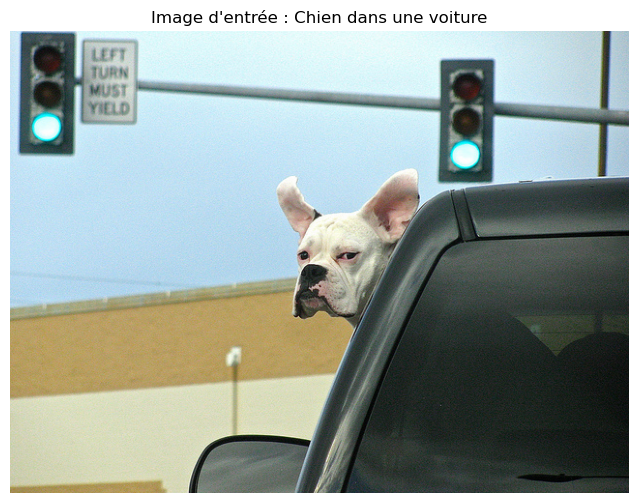

In [ ]:
import os
from urllib.request import urlopen
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

# Chargement de l'image et définition des textes
img_path = "./dog_and_car.png"
img = Image.open(img_path).convert("RGB")
texts = ["dog", "car", "traffic lights", "a dog in a car waiting for traffic lights"] 

# Exemple alternatif commenté
# url = "http://l7.alamy.com/zooms/1e7674256f464050bf142a5d21407ede/single-cowboy-guiding-a-line-of-horses-through-the-desert-bnh6m3.jpg"
# img = Image.open(urlopen(url))
# texts = ["cowboy", "horse", "desert", "single cowboy guiding a line of horses through the desert"]

plt.figure(figsize=(10, 6))
plt.imshow(img)
plt.axis('off')
plt.title('Image d\'entrée : Chien dans une voiture')
plt.show()

## 6. Encodage standard CLIP - Baseline

Commençons par l'approche standard de CLIP pour établir une baseline. Cette méthode ne donne qu'un score global de similarité sans information spatiale.


In [ ]:
# Préprocessing standard de CLIP
img_preprocessed = preprocess(img).cuda().unsqueeze(0)
text_processed = clip.tokenize(texts).cuda()

# Extraction des embeddings texte
text_embedding = clipmodel.encode_text(text_processed)
text_embedding = F.normalize(text_embedding, dim=-1)
print("[text embedding shape]:", text_embedding.shape)

# Extraction des embeddings image (méthode standard)
ori_img_embedding = clipmodel.encode_image(img_preprocessed)
ori_img_embedding = F.normalize(ori_img_embedding, dim=-1)
print("[image embedding shape]:", ori_img_embedding.shape)

# Calcul de similarité cosinus
cosine_standard = (ori_img_embedding @ text_embedding.T)
print("[similarités standard]:", cosine_standard)
print("\nInterprétation:")
for i, text in enumerate(texts):
    print(f"  '{text}': {cosine_standard[0][i]:.4f}")

[text embedding shape]: torch.Size([4, 512])
[image embedding shape]: torch.Size([1, 512])
[similarités standard]: tensor([[0.2678, 0.2377, 0.2605, 0.3503]], device='cuda:0',
       dtype=torch.float16, grad_fn=<MmBackward0>)

Interprétation:
  'dog': 0.2678
  'car': 0.2377
  'traffic lights': 0.2605
  'a dog in a car waiting for traffic lights': 0.3503


## 7. Application de l'encodage dense

Maintenant, utilisons notre encodage dense pour obtenir les features spatiales de chaque patch de l'image.


In [ ]:
# Préprocessing avec la fonction personnalisée
img_preprocessed_k = imgprocess(img).cuda().unsqueeze(0)
print(f"Taille après préprocessing custom: {img_preprocessed_k.shape}")

# Encodage dense avec extraction des couches d'attention
outputs, last_feat, vs, qs, ks, attns, atten_outs, map_size = clip_encode_dense(
    img_preprocessed_k, n=1)

print(
    f"Nombre de patches: {map_size[0]} x {map_size[1]} = {map_size[0]*map_size[1]}")
print(f"Dimensions de sortie: {outputs.shape}")

# Embedding du token [CLS] (représentation globale)
img_embedding = F.normalize(outputs[:, 0], dim=-1)
print("[image embedding shape]:", img_embedding.shape)
cosine = (img_embedding @ text_embedding.T)[0]
print("[similarités dense]:", cosine)

# Features des patches individuels
p_final = F.normalize(outputs[:, 1:], dim=-1)
cosine_p = (
    p_final @ text_embedding.T)[0].transpose(1, 0).reshape(-1, *map_size)
print("[similarité par patch - shape]:", cosine_p.shape)
print("  -> 4 prompts × 30×40 patches")

Taille après préprocessing custom: torch.Size([1, 3, 480, 640])
[vision_width and vision_heads]: 768 12
[POS shape]: torch.Size([1, 768, 14, 14]) (30, 40)
Nombre de patches: 30 x 40 = 1200
Dimensions de sortie: torch.Size([1, 1201, 512])
[image embedding shape]: torch.Size([1, 512])
[similarités dense]: tensor([0.1901, 0.2028, 0.2117, 0.1714], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
[similarité par patch - shape]: torch.Size([4, 30, 40])
  -> 4 prompts × 30×40 patches


## 8. Génération des cartes Grad-ECLIP - Théorie

### Principe de Grad-ECLIP

**Grad-ECLIP** combine trois éléments clés pour générer des cartes d'explication :

#### 1. **Gradients** (∇c)

- Calcul du gradient de la similarité cosinus par rapport aux sorties d'attention
- Indique comment chaque neurone influence le score final

#### 2. **Values (V)**

- Les valeurs d'attention contiennent l'information sémantique des patches
- Représentent "ce que chaque patch apporte à la représentation"

#### 3. **Similarité Query-Key**

- Mesure l'attention entre le token [CLS] et chaque patch
- Indique quels patches sont "consultés" pour la décision finale

#### Formule Grad-ECLIP :

```
Carte_Grad_ECLIP = Σ (∇c * V * Similarité_QK)
```

où :

- **∇c** est le gradient de la similarité cosinus
- **V** sont les vecteurs de valeur des patches
- **Similarité_QK** est la similarité entre les queries et les keys


## 9. Algorithmes de génération des cartes d'attention

Nous détaillons ici les algorithmes utilisés pour générer les cartes Grad-ECLIP et les comparer à des méthodes comme Grad-CAM.


In [ ]:
# Algorithmes de génération des cartes d'attention

def sim_qk(q, k):
    """Calcul de similarité entre query et key"""
    q_cls = F.normalize(q[:1, 0, :], dim=-1)
    k_patch = F.normalize(k[1:, 0, :], dim=-1)

    cosine_qk = (q_cls * k_patch).sum(-1)
    cosine_qk_max = cosine_qk.max(dim=-1, keepdim=True)[0]
    cosine_qk_min = cosine_qk.min(dim=-1, keepdim=True)[0]
    cosine_qk = (cosine_qk-cosine_qk_min) / (cosine_qk_max-cosine_qk_min)
    return cosine_qk


def grad_eclip(c, qs, ks, vs, attn_outputs, map_size):
    """Génération de carte Grad-ECLIP"""
    tmp_maps = []
    for q, k, v, attn_output in zip(qs, ks, vs, attn_outputs):
        # Gradient sur la dernière sortie d'attention
        grad = torch.autograd.grad(c, attn_output, retain_graph=True)[0]

        grad_cls = grad[:1, 0, :]
        v_patch = v[1:, 0, :]
        cosine_qk = sim_qk(q, k).reshape(-1)
        tmp_maps.append((grad_cls * v_patch * cosine_qk[:, None]).sum(-1))

    emap = F.relu_(torch.stack(tmp_maps, dim=0)).sum(0)
    return emap.reshape(*map_size)


def self_attn(attns, map_size):
    """Extraction de l'attention du token CLS"""
    attn_patch = attns[-1][0, :1, 1:].reshape(*map_size)
    print("[attn of cls token on lastv]:", attn_patch.shape)
    return attn_patch


def grad_cam(c, feat, map_size):
    """GRAD-CAM: utilise les sorties de features de la dernière couche d'attention"""
    grad = torch.autograd.grad(c, feat, retain_graph=True)[0]
    grad_weight = grad.mean(0, keepdim=True)
    grad_cam = F.relu_((grad_weight * feat).sum(-1))
    grad_cam = grad_cam[1:].reshape(*map_size)
    return grad_cam

## 10. Génération et visualisation des cartes d'attention

Nous générons les cartes d'attention pour chaque texte et comparons les résultats de Grad-ECLIP et Grad-CAM.


Textes analysés: ['dog', 'car', 'traffic lights', 'a dog in a car waiting for traffic lights']


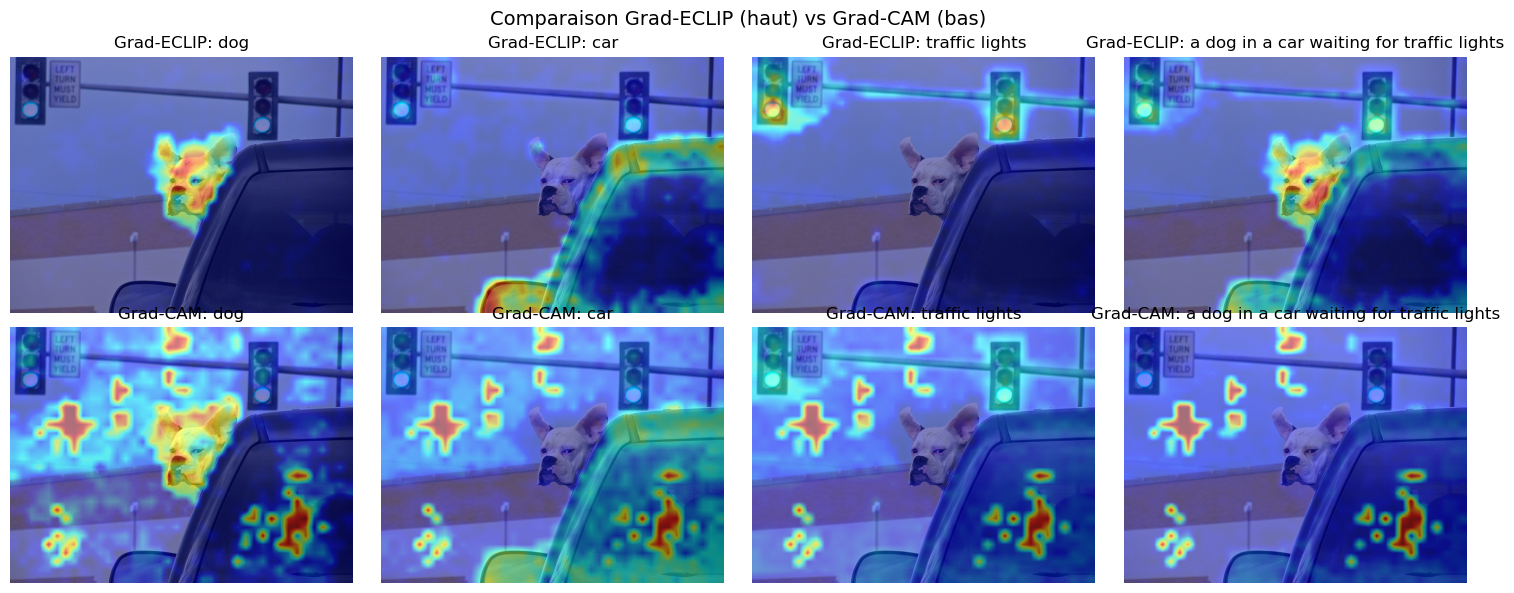

In [ ]:
# Génération et visualisation des cartes d'attention

# Génération des cartes pour chaque texte
grad_emaps = []
grad_cams = []
self_attns = []

for i, c in enumerate(cosine):
    grad_emaps.append(grad_eclip(c, qs, ks, vs, atten_outs, map_size))
    grad_cams.append(grad_cam(c, last_feat, map_size))
    self_attns.append(self_attn(attns, map_size))

# Affichage des résultats avec 3 méthodes
print("Textes analysés:", texts)
h, w = img.size
resize = T.Resize((w, h))

fig, axs = plt.subplots(ncols=len(cosine), nrows=3, figsize=(20, 12))
fig.suptitle('Comparaison des méthodes d\'explicabilité', fontsize=16)

# Labels pour les méthodes
method_labels = ['Grad-ECLIP', 'Grad-CAM', 'Self-Attention']

for i, ax_col in enumerate(axs.T):
    # Grad-ECLIP (ligne du haut)
    tmp = grad_emaps[i].clone()
    tmp -= tmp.min()
    tmp /= tmp.max()
    c_ret = visualize(tmp.detach().cpu(), img, resize)
    ax_col[0].axis('off')
    ax_col[0].imshow(c_ret)
    ax_col[0].set_title(f'{method_labels[0]}: "{texts[i]}"', fontsize=12)

    # Calcul et affichage des statistiques
    coverage = (tmp > 0.5).float().mean().item()
    max_attention = tmp.max().item()
    ax_col[0].text(10, 30, f'Coverage: {coverage:.2%}\nMax: {max_attention:.3f}',
                   bbox=dict(boxstyle="round,pad=0.3",
                             facecolor="white", alpha=0.8),
                   fontsize=10)

    # Grad-CAM (ligne du milieu)
    tmp = grad_cams[i].clone()
    tmp -= tmp.min()
    tmp /= tmp.max()
    c_ret = visualize(tmp.detach().cpu(), img, resize)
    ax_col[1].axis('off')
    ax_col[1].imshow(c_ret)
    ax_col[1].set_title(f'{method_labels[1]}: "{texts[i]}"', fontsize=12)

    # Self-Attention (ligne du bas)
    tmp = self_attns[i].clone()
    tmp -= tmp.min()
    tmp /= tmp.max()
    c_ret = visualize(tmp.detach().cpu(), img, resize)
    ax_col[2].axis('off')
    ax_col[2].imshow(c_ret)
    ax_col[2].set_title(f'{method_labels[2]}: "{texts[i]}"', fontsize=12)

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

In [ ]:

# Nouvelle cellule d'analyse comparative approfondie
import scipy.stats as stats
print("ANALYSE COMPARATIVE DÉTAILLÉE")
print("="*80)

# Calcul des corrélations entre méthodes

correlation_results = {}
for i, text in enumerate(texts):
    print(f"\nTexte: '{text}'")
    print("-" * 50)

    # Récupération des cartes normalisées
    maps = {}
    for name, map_data in [("Grad-ECLIP", grad_emaps[i]),
                           ("Grad-CAM", grad_cams[i]),
                           ("Self-Attention", self_attns[i])]:
        normalized = map_data.clone()
        normalized -= normalized.min()
        normalized /= normalized.max()
        maps[name] = normalized.flatten().cpu().numpy()

    # Calcul des corrélations de Pearson
    methods = list(maps.keys())
    for j in range(len(methods)):
        for k in range(j+1, len(methods)):
            corr, p_value = stats.pearsonr(maps[methods[j]], maps[methods[k]])
            pair = f"{methods[j]} vs {methods[k]}"
            print(f"  Corrélation {pair:30}: r={corr:5.3f} (p={p_value:.2e})")

            if text not in correlation_results:
                correlation_results[text] = {}
            correlation_results[text][pair] = corr

# Résumé des corrélations moyennes
print(f"\n{'RÉSUMÉ DES CORRÉLATIONS MOYENNES':^80}")
print("="*80)

pairs = ["Grad-ECLIP vs Grad-CAM",
         "Grad-ECLIP vs Self-Attention", "Grad-CAM vs Self-Attention"]
for pair in pairs:
    avg_corr = np.mean([correlation_results[text][pair] for text in texts])
    std_corr = np.std([correlation_results[text][pair] for text in texts])
    print(f"{pair:35}: {avg_corr:6.3f} ± {std_corr:5.3f}")

print("\nINTERPRÉTATION:")
print("• Corrélation proche de 1: Méthodes similaires")
print("• Corrélation proche de 0: Méthodes complémentaires")
print("• Corrélation négative: Méthodes opposées")

# Analyse de robustesse des cartes d'attention

Cette section évalue la robustesse des cartes d'attention générées face à des variations d'hyperparamètres.


In [ ]:
# Nouvelle cellule pour analyse de robustesse
def analyze_attention_robustness():
    """Analyse la robustesse des cartes d'attention avec différents hyperparamètres"""

    print("ANALYSE DE ROBUSTESSE")
    print("="*60)

    # Test avec différents facteurs d'échelle
    scale_factors = [0.8, 1.0, 1.2]
    robustness_results = {}

    for scale in scale_factors:
        print(f"\nTest avec facteur d'échelle: {scale}")

        # Préprocessing avec différente échelle
        img_scaled = imgprocess(img, scale_factor=scale).cuda().unsqueeze(0)

        # Encodage dense
        try:
            outputs_scaled, last_feat_scaled, vs_scaled, qs_scaled, ks_scaled, attns_scaled, atten_outs_scaled, map_size_scaled = clip_encode_dense(
                img_scaled, n=1)

            # Calcul des embeddings
            img_embedding_scaled = F.normalize(outputs_scaled[:, 0], dim=-1)
            cosine_scaled = (img_embedding_scaled @ text_embedding.T)[0]

            print(f"  Taille de carte: {map_size_scaled}")
            print(
                f"  Similarités: {[f'{c:.3f}' for c in cosine_scaled.cpu().numpy()]}")

            robustness_results[scale] = {
                'cosine': cosine_scaled,
                'map_size': map_size_scaled
            }

        except Exception as e:
            print(f"  Erreur avec échelle {scale}: {e}")

    # Analyse de la stabilité des scores
    print(f"\n{'STABILITÉ DES SCORES DE SIMILARITÉ':^60}")
    print("-" * 60)

    for i, text in enumerate(texts):
        scores = [robustness_results[scale]['cosine'][i].item()
                  for scale in scale_factors if scale in robustness_results]
        if len(scores) > 1:
            mean_score = np.mean(scores)
            std_score = np.std(scores)
            cv = std_score / mean_score if mean_score != 0 else float('inf')
            print(f"{text:25}: {mean_score:.3f} ± {std_score:.3f} (CV: {cv:.1%})")


# Exécution de l'analyse de robustesse
analyze_attention_robustness()